In [1]:
print("hello")

hello



=== Optimizer Metrics ===
          runtime_sec  gradient_evals  final_loss
SGD          0.000860           100.0   -1.101083
Momentum     0.000926           100.0   -1.100474
AdaGrad      0.000892           100.0    7.676787
Adam         0.001358           100.0   -1.098099
IDAM         0.000906           100.0   -1.101083


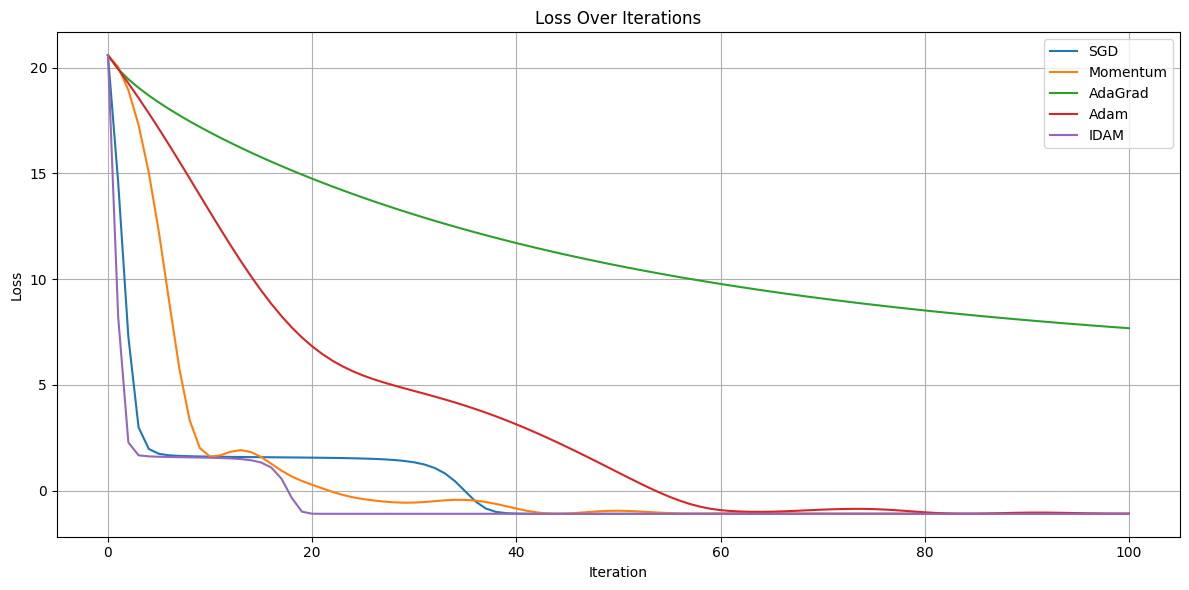

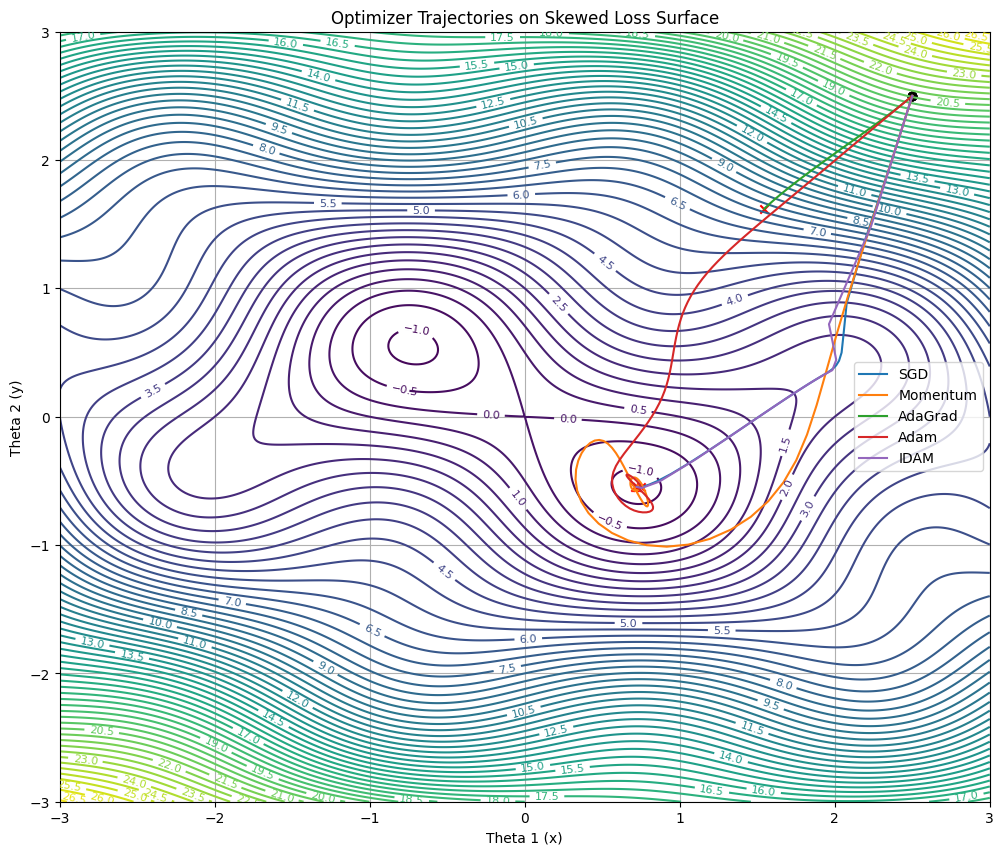

In [16]:
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------------------
# Define the loss function and gradient
# ----------------------------------------
def loss_function(theta):
    x, y = theta
    return 0.5 * x**2 + 2 * y**2 + 0.5 * x * y + 2 * np.sin(2 * x) * np.sin(2 * y)

def gradient(theta):
    x, y = theta
    dx = x + 0.5 * y + 4 * np.cos(2 * x) * np.sin(2 * y)
    dy = 4 * y + 0.5 * x + 4 * np.sin(2 * x) * np.cos(2 * y)
    return np.array([dx, dy])

# ----------------------------------------
# Optimization function
# ----------------------------------------
def optimization(methods, lr=0.05, steps=100, beta=0.9, alpha=0.1, eps=1e-8):
    metrics = {}
    trajectories = {}
    loss_histories = {}

    for method in methods:
        theta = np.array([2.5, 2.5])  # Starting point
        trajectory = [theta.copy()]
        m = np.zeros(2)
        v = np.zeros(2)
        G = np.zeros(2)
        theta_prev = theta.copy()
        grad_calls = 0

        start_time = time.time()

        for k in range(1, steps + 1):
            grad = gradient(theta)
            grad_calls += 1

            if method == "SGD":
                theta -= lr * grad

            elif method == "Momentum":
                m = beta * m + (1 - beta) * grad
                theta -= lr * m

            elif method == "AdaGrad":
                G += grad**2
                theta -= lr * grad / (np.sqrt(G) + eps)

            elif method == "Adam":
                m = beta * m + (1 - beta) * grad
                v = beta * v + (1 - beta) * grad**2
                m_hat = m / (1 - beta**k)
                v_hat = v / (1 - beta**k)
                theta -= lr * m_hat / (np.sqrt(v_hat) + eps)

            elif method == "IDAM":
                displacement = theta - theta_prev
                eta_adaptive = alpha / (np.sqrt(1 + displacement**2))
                theta_prev = theta.copy()
                theta -= eta_adaptive * grad

            trajectory.append(theta.copy())

        runtime = time.time() - start_time
        trajectories[method] = np.array(trajectory)
        losses = [loss_function(t) for t in trajectory]
        loss_histories[method] = losses
        metrics[method] = {
            "runtime_sec": runtime,
            "gradient_evals": grad_calls,
            "final_loss": losses[-1]
        }

    return metrics, trajectories, loss_histories

# ----------------------------------------
# Run the optimization and collect metrics
# ----------------------------------------
methods = ["SGD", "Momentum", "AdaGrad", "Adam", "IDAM"]
metrics, trajectories, loss_histories = optimization(methods)

# Display metrics
results_df = pd.DataFrame(metrics).T
print("\n=== Optimizer Metrics ===")
print(results_df)

# ----------------------------------------
# Plot 1: Loss over iterations
# ----------------------------------------
plt.figure(figsize=(12, 6))
for method, losses in loss_histories.items():
    plt.plot(losses, label=method)
plt.title("Loss Over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ----------------------------------------
# Plot 2: Trajectories on loss surface
# ----------------------------------------
x_vals = np.linspace(-3, 3, 400)
y_vals = np.linspace(-3, 3, 400)
X, Y = np.meshgrid(x_vals, y_vals)
Z = loss_function([X, Y])

plt.figure(figsize=(12, 10))
contours = plt.contour(X, Y, Z, levels=60, cmap='viridis')
plt.clabel(contours, inline=True, fontsize=8)

for method, traj in trajectories.items():
    plt.plot(traj[:, 0], traj[:, 1], label=method)
    plt.scatter(traj[0, 0], traj[0, 1], color='black', marker='o')  # Start
    plt.scatter(traj[-1, 0], traj[-1, 1], color='red', marker='x')  # End

plt.title("Optimizer Trajectories on Skewed Loss Surface")
plt.xlabel("Theta 1 (x)")
plt.ylabel("Theta 2 (y)")
plt.legend()
plt.grid(True)
plt.show()
